# Post Test set

In [1]:
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from hyperspy.learn.rpca import rpca_godec, orpca
path = 'data/MOLLI_post_dataset/test/9353628_20140129_MOLLI_1.npy'
vols = np.load(path).transpose(1, 2, 0)
x, y, z = vols.shape
print(f"x is {x} and y is {y} and z is {z}")
M = vols.reshape(x*y, z)
print(M.shape)
# low, sparse, U, S, V = rpca_godec(M, rank=5)
# low_matrix = low.reshape((x, y, z))
# sparse_matrix = sparse.reshape((x, y, z))

# fig = plt.figure(figsize=(11, 3))
# title_font_size=8
# title_pad = 10
# for i in range(z):
#     ax1 = fig.add_subplot(3, 11, 1+i)
#     plt.imshow(vols[..., i], cmap='gray')
#     plt.axis('off')
#     ax1.set_title(f"Timestep{i+1}", fontsize=title_font_size, pad=title_pad)

#     ax2 = fig.add_subplot(3, 11, 12+i)
#     plt.imshow(low_matrix[..., i], cmap='gray')
#     plt.axis('off')

#     ax3 = fig.add_subplot(3, 11, 23+i)
#     plt.imshow(sparse_matrix[..., i], cmap='gray')
#     plt.axis('off')

x is 224 and y is 224 and z is 11
(50176, 11)


In [2]:
import pandas as pd
df = pd.DataFrame()
df_2 = pd.DataFrame()

## Test Metrics

### Original volume

#### First Eigen Component percentage

In [3]:
from scripts.utils import *
orig_path = 'data/MOLLI_post_dataset/test'
orig_pca_changes = []
for file in sorted(glob.glob(os.path.join(orig_path, '*.npy'))):
    vols = np.load(file).transpose(1, 2, 0)
    eig_org, org_K, org_dis = pca(vols, topk=1)
    orig_pca_changes.append(org_dis)
print(f"Mean of original PCA is {np.mean(np.array(orig_pca_changes))}")

Mean of original PCA is 0.8590354716904918


#### T1 fitting

In [4]:
import scipy.io
from pathlib import Path
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import ndimage

title_font_size=8
title_pad = 10
def plot_t1_changes(path, size=(20, 36)):
    fig = plt.figure(figsize=size)
    t1err_square_list = []
    t1err_heart_list = []
    t1err_myo_list = []
    subject_list = []
    
    neighbor = ndimage.generate_binary_structure(2, 2)
    for i, file in enumerate(sorted(glob.glob(os.path.join(path, '*.mat')))):
        subject = Path(file).stem
        subject_list.append(subject)
        fd = scipy.io.loadmat(file)
        SD_err = fd['S']
        areamask = fd['areamask']
        itemindex = np.where(areamask == 1)
        x1, x2 = itemindex[0][0], itemindex[0][-1]
        y1, y2 = itemindex[1][0], itemindex[1][-1]
        epi = fd['epi_BW']
        endo = fd['endo_BW']
        heartmask = ndimage.binary_dilation(epi, structure=neighbor, iterations=2).astype(epi.dtype)
        myomask = heartmask - endo
        
        errmap = SD_err * areamask
        square_SD_err = np.mean(errmap[areamask==1])
        t1err_square_list.append(square_SD_err)
        fig.add_subplot(10, 6, 1+i*6)
        ax = plt.gca()
        im = ax.imshow(errmap[x1:x2, y1:y2], cmap='jet', vmin=0, vmax=50)
        ax.axis('off')
        ax.set_title(f"Average SD error {(square_SD_err):.4f}", fontsize=title_font_size, pad=title_pad)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

        t1_params_pre = fd['pmap_mse']
        a = t1_params_pre[:, :, 0]
        b = t1_params_pre[:, :, 1]
        c = t1_params_pre[:, :, 2]
        t1map = c * (b - 1)
        fig.add_subplot(10, 6, 2+i*6)
        ax = plt.gca()
        im = ax.imshow(t1map[x1:x2, y1:y2], cmap='jet', vmin=0, vmax=1500)
        ax.axis('off')
        ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

        hearterrmap = SD_err * heartmask
        heartt1map = t1map * heartmask
        heart_SD_err = np.mean(hearterrmap[heartmask==1])
        t1err_heart_list.append(heart_SD_err)

        fig.add_subplot(10, 6, 3+i*6)
        ax = plt.gca()
        im = ax.imshow(hearterrmap[x1:x2, y1:y2], cmap='jet', vmin=0, vmax=50)
        ax.axis('off')
        ax.set_title(f"Average SD error {(heart_SD_err):.4f} in ROI", fontsize=title_font_size, pad=title_pad)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

        fig.add_subplot(10, 6, 4+i*6)
        ax = plt.gca()
        im = ax.imshow(heartt1map[x1:x2, y1:y2], cmap='jet', vmin=0, vmax=1500)
        ax.axis('off')
        ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

        myoerrmap = SD_err * myomask
        myot1map = t1map * myomask
        myo_SD_err = np.mean(myoerrmap[myomask==1])
        t1err_myo_list.append(myo_SD_err)

        fig.add_subplot(10, 6, 5+i*6)
        ax = plt.gca()
        im = ax.imshow(myoerrmap[x1:x2, y1:y2], cmap='jet', vmin=0, vmax=50)
        ax.axis('off')
        ax.set_title(f"Average SD error {(myo_SD_err):.4f} in Myocardium", fontsize=title_font_size, pad=title_pad)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

        fig.add_subplot(10, 6, 6+i*6)
        ax = plt.gca()
        im = ax.imshow(myot1map[x1:x2, y1:y2], cmap='jet', vmin=0, vmax=2500)
        ax.axis('off')
        ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)
    plt.subplots_adjust(left=0.0001,right=0.9, top=0.95, bottom=0.1,)
    return fig, subject_list, t1err_square_list, t1err_heart_list, t1err_myo_list

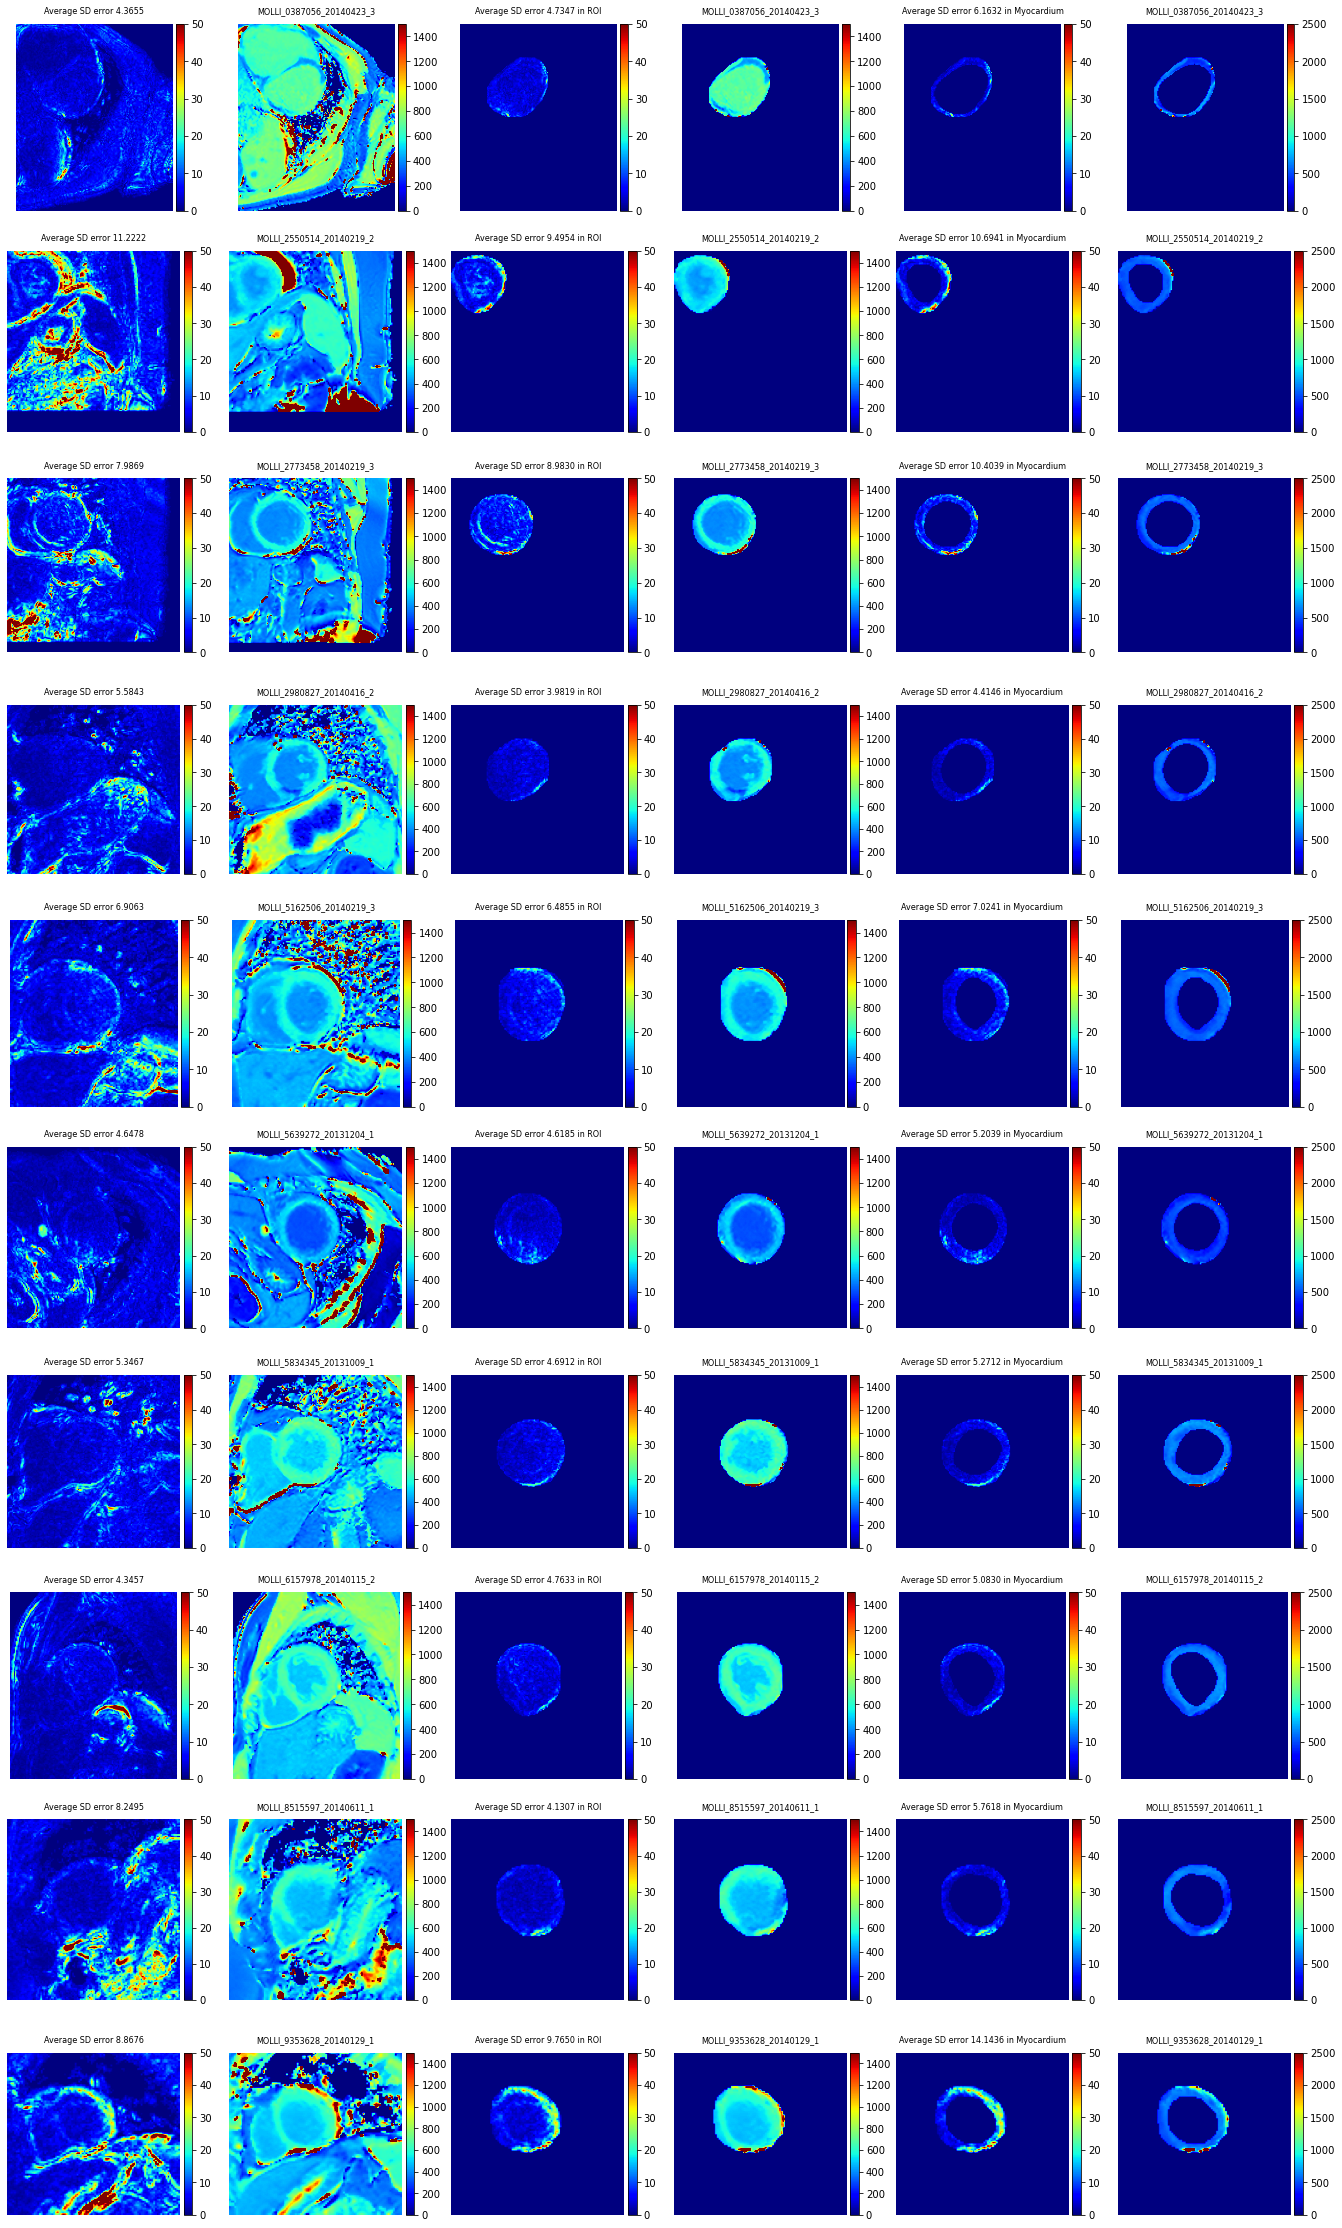

In [5]:
path = "data/MOLLI_post_dataset/T1_SDerr"

fig, subject_list, orig_t1err_square_list, orig_t1err_heart_list, orig_t1err_myo_list = plot_t1_changes(path)
plt.savefig(f"data/MOLLI_post_dataset/T1_SDerr/orig_t1err.png", dpi=300)

df['Cases'] = subject_list
df['Raw Square T1err'] = orig_t1err_square_list
df['Raw ROI T1err'] = orig_t1err_heart_list
df['Raw Myo T1err'] = orig_t1err_myo_list
df_2['Cases'] = subject_list
df_2['Raw PCA'] = orig_pca_changes

### Round 1

In [6]:
import voxelmorph_group as vxm  # nopep8
import numpy as np
import glob
import os
jacobian = vxm.losses.Jacobian().loss

In [7]:
r = 1
root = f"results/MOLLI_pre/group/rank_5_5_5_5_5_5_5/ncc/smooth/image_loss_weight1/cycle_loss_weight0.01/weight0.001/bspline/cps4_svfsteps7_svfscale1/e80/test_MOLLI_post"
base_path = f"{root}/round{r}"

#### First Eigen Component percentage

In [8]:
path = f"{base_path}/moved"
pca_changes = []
for file in sorted(glob.glob(os.path.join(path, '*.npy'))):
    vols = np.load(file).transpose(1, 2, 0)
    eig_org, org_K, org_dis = pca(vols, topk=1)
    pca_changes.append(org_dis)
print(f"Mean of Round 1 PCA is {np.mean(np.array(pca_changes))} and std is {np.std(np.array(pca_changes))}")

Mean of Round 1 PCA is 0.8628297984784352 and std is 0.021600301992927787


#### Jacobian Determination

In [9]:
folding_ratio_list = []
mag_det_jac_det_list = []
path = f"{base_path}/warp"
for file in sorted(glob.glob(os.path.join(path, '*.nii'))):
    disp = vxm.py.utils.load_volfile(file).transpose(2, 3, 0, 1)
    folding_ratio, mag_det_jac_det = jacobian(disp)
    folding_ratio_list.append(folding_ratio)
    mag_det_jac_det_list.append(mag_det_jac_det)

print(f"Mean of folding ratio is {np.mean(np.array(folding_ratio_list))}")
print(f"Mean of mag det jac det is {np.mean(np.array(mag_det_jac_det_list))}")

Mean of folding ratio is 0.0
Mean of mag det jac det is 0.0030967709608376026


#### T1 fitting

In [10]:
import matplotlib.pyplot as plt

path = f"{base_path}/T1_SDerr"

fig, subject_list, t1err_square_list, t1err_heart_list, t1err_myo_list = plot_t1_changes(path)
plt.savefig(f"{base_path}/t1_SDerr.png", dpi=300)

df['R1 Square T1err'] = t1err_square_list
df['R1 ROI T1err'] = t1err_heart_list
df['R1 Myo T1err'] = t1err_myo_list
df_2['R1 PCA'] = pca_changes
df_2['R1 Det'] = mag_det_jac_det_list

ValueError: Length of values (0) does not match length of index (10)

<Figure size 1440x2592 with 0 Axes>

### Round 2

In [ ]:
r = 2
base_path = f"{root}/round{r}"

#### First Eigen Component percentage

In [ ]:
path = f"{base_path}/moved"
pca_changes = []
for file in sorted(glob.glob(os.path.join(path, '*.npy'))):
    vols = np.load(file).transpose(1, 2, 0)
    eig_org, org_K, org_dis = pca(vols, topk=1)
    pca_changes.append(org_dis)
print(f"Mean of Round 2 PCA is {np.mean(np.array(pca_changes))} and std is {np.std(np.array(pca_changes))}")

#### Jacobian Determination

In [ ]:
folding_ratio_list = []
mag_det_jac_det_list = []
path = f"{base_path}/warp"
for file in sorted(glob.glob(os.path.join(path, '*.nii'))):
    disp = vxm.py.utils.load_volfile(file).transpose(2, 3, 0, 1)
    folding_ratio, mag_det_jac_det = jacobian(disp)
    folding_ratio_list.append(folding_ratio)
    mag_det_jac_det_list.append(mag_det_jac_det)

print(f"Mean of folding ratio is {np.mean(np.array(folding_ratio_list))}")
print(f"Mean of mag det jac det is {np.mean(np.array(mag_det_jac_det_list))}")

#### T1 fitting

In [ ]:
import matplotlib.pyplot as plt

path = f"{base_path}/T1_SDerr"

fig, subject_list, t1err_square_list, t1err_heart_list, t1err_myo_list = plot_t1_changes(path)
plt.savefig(f"{base_path}/t1_SDerr.png", dpi=300)

df['R2 Square T1err'] = t1err_square_list
df['R2 ROI T1err'] = t1err_heart_list
df['R2 Myo T1err'] = t1err_myo_list
df_2['R2 PCA'] = pca_changes
df_2['R2 Det'] = mag_det_jac_det_list

### Round 3

In [ ]:
r = 3
base_path = f"{root}/round{r}"

#### First Eigen Component percentage

In [ ]:
path = f"{base_path}/moved"
r5_pca_changes = []
for file in sorted(glob.glob(os.path.join(path, '*.npy'))):
    vols = np.load(file).transpose(1, 2, 0)
    eig_org, org_K, org_dis = pca(vols, topk=1)
    r5_pca_changes.append(org_dis)
print(f"Mean of Round 2 PCA is {np.mean(np.array(r5_pca_changes))} and std is {np.std(np.array(r5_pca_changes))}")

#### Jacobian Determination

In [ ]:
r5_folding_ratio_list = []
r5_mag_det_jac_det_list = []
path = f"{base_path}/warp"
for file in sorted(glob.glob(os.path.join(path, '*.nii'))):
    disp = vxm.py.utils.load_volfile(file).transpose(2, 3, 0, 1)
    folding_ratio, mag_det_jac_det = jacobian(disp)
    r5_folding_ratio_list.append(folding_ratio)
    r5_mag_det_jac_det_list.append(mag_det_jac_det)

print(f"Mean of folding ratio is {np.mean(np.array(r5_folding_ratio_list))}")
print(f"Mean of mag det jac det is {np.mean(np.array(r5_mag_det_jac_det_list))}")

#### T1 fitting

In [ ]:
import matplotlib.pyplot as plt

path = f"{base_path}/T1_SDerr"

fig, subject_list, t1err_square_list, t1err_heart_list, t1err_myo_list = plot_t1_changes(path)
plt.savefig(f"{base_path}/t1_SDerr.png", dpi=300)

df['R3 Square T1err'] = t1err_square_list
df['R3 ROI T1err'] = t1err_heart_list
df['R3 Myo T1err'] = t1err_myo_list
df_2['R3 PCA'] = pca_changes
df_2['R3 Det'] = mag_det_jac_det_list

### Round 4

In [ ]:
r = 4
base_path = f"{root}/round{r}"

#### First Eigen Component percentage

In [ ]:
path = f"{base_path}/moved"
pca_changes = []
for file in sorted(glob.glob(os.path.join(path, '*.npy'))):
    vols = np.load(file).transpose(1, 2, 0)
    eig_org, org_K, org_dis = pca(vols, topk=1)
    pca_changes.append(org_dis)
print(f"Mean of Round 2 PCA is {np.mean(np.array(pca_changes))} and std is {np.std(np.array(pca_changes))}")

#### Jacobian Determination

In [ ]:
folding_ratio_list = []
mag_det_jac_det_list = []
path = f"{base_path}/warp"
for file in sorted(glob.glob(os.path.join(path, '*.nii'))):
    disp = vxm.py.utils.load_volfile(file).transpose(2, 3, 0, 1)
    folding_ratio, mag_det_jac_det = jacobian(disp)
    folding_ratio_list.append(folding_ratio)
    mag_det_jac_det_list.append(mag_det_jac_det)

print(f"Mean of folding ratio is {np.mean(np.array(folding_ratio_list))}")
print(f"Mean of mag det jac det is {np.mean(np.array(mag_det_jac_det_list))}")

#### T1 fitting

In [ ]:
import matplotlib.pyplot as plt

path = f"{base_path}/T1_SDerr"

fig, subject_list, t1err_square_list, t1err_heart_list, t1err_myo_list = plot_t1_changes(path)
plt.savefig(f"{base_path}/t1_SDerr.png", dpi=300)

df['R4 Square T1err'] = t1err_square_list
df['R4 ROI T1err'] = t1err_heart_list
df['R4 Myo T1err'] = t1err_myo_list
df_2['R4 PCA'] = pca_changes
df_2['R4 Det'] = mag_det_jac_det_list

### Round 5

In [ ]:
r = 5
base_path = f"{root}/round{r}"

#### First Eigen Component percentage

In [ ]:
path = f"{base_path}/moved"
pca_changes = []
for file in sorted(glob.glob(os.path.join(path, '*.npy'))):
    vols = np.load(file).transpose(1, 2, 0)
    eig_org, org_K, org_dis = pca(vols, topk=1)
    pca_changes.append(org_dis)
print(f"Mean of Round 2 PCA is {np.mean(np.array(pca_changes))} and std is {np.std(np.array(pca_changes))}")

#### Jacobian Determination

In [ ]:
folding_ratio_list = []
mag_det_jac_det_list = []
path = f"{base_path}/warp"
for file in sorted(glob.glob(os.path.join(path, '*.nii'))):
    disp = vxm.py.utils.load_volfile(file).transpose(2, 3, 0, 1)
    folding_ratio, mag_det_jac_det = jacobian(disp)
    folding_ratio_list.append(folding_ratio)
    mag_det_jac_det_list.append(mag_det_jac_det)

print(f"Mean of folding ratio is {np.mean(np.array(folding_ratio_list))}")
print(f"Mean of mag det jac det is {np.mean(np.array(mag_det_jac_det_list))}")

#### T1 fitting

In [ ]:
import matplotlib.pyplot as plt

path = f"{base_path}/T1_SDerr"

fig, subject_list, t1err_square_list, t1err_heart_list, t1err_myo_list = plot_t1_changes(path)
plt.savefig(f"{base_path}/t1_SDerr.png", dpi=300)

df['R5 Square T1err'] = t1err_square_list
df['R5 ROI T1err'] = t1err_heart_list
df['R5 Myo T1err'] = t1err_myo_list
df_2['R5 PCA'] = pca_changes
df_2['R5 Det'] = mag_det_jac_det_list

### Round 6

In [ ]:
r = 6
base_path = f"{root}/round{r}"

#### First Eigen Component percentage

In [ ]:
path = f"{base_path}/moved"
pca_changes = []
for file in sorted(glob.glob(os.path.join(path, '*.npy'))):
    vols = np.load(file).transpose(1, 2, 0)
    eig_org, org_K, org_dis = pca(vols, topk=1)
    pca_changes.append(org_dis)
print(f"Mean of Round 2 PCA is {np.mean(np.array(pca_changes))} and std is {np.std(np.array(pca_changes))}")

#### Jacobian Determination

In [ ]:
folding_ratio_list = []
mag_det_jac_det_list = []
path = f"{base_path}/warp"
for file in sorted(glob.glob(os.path.join(path, '*.nii'))):
    disp = vxm.py.utils.load_volfile(file).transpose(2, 3, 0, 1)
    folding_ratio, mag_det_jac_det = jacobian(disp)
    folding_ratio_list.append(folding_ratio)
    mag_det_jac_det_list.append(mag_det_jac_det)

print(f"Mean of folding ratio is {np.mean(np.array(folding_ratio_list))}")
print(f"Mean of mag det jac det is {np.mean(np.array(mag_det_jac_det_list))}")

#### T1 fitting

In [ ]:
import matplotlib.pyplot as plt

path = f"{base_path}/T1_SDerr"

fig, subject_list, t1err_square_list, t1err_heart_list, t1err_myo_list = plot_t1_changes(path)
plt.savefig(f"{base_path}/t1_SDerr.png", dpi=300)

df['R6 Square T1err'] = t1err_square_list
df['R6 ROI T1err'] = t1err_heart_list
df['R6 Myo T1err'] = t1err_myo_list
df_2['R6 PCA'] = pca_changes
df_2['R6 Det'] = mag_det_jac_det_list

### Round 7

In [ ]:
r = 7
base_path = f"{root}/round{r}"

#### First Eigen Component percentage

In [ ]:
path = f"{base_path}/moved"
pca_changes = []
for file in sorted(glob.glob(os.path.join(path, '*.npy'))):
    vols = np.load(file).transpose(1, 2, 0)
    eig_org, org_K, org_dis = pca(vols, topk=1)
    pca_changes.append(org_dis)
print(f"Mean of Round 2 PCA is {np.mean(np.array(pca_changes))} and std is {np.std(np.array(pca_changes))}")

#### Jacobian Determination

In [ ]:
folding_ratio_list = []
mag_det_jac_det_list = []
path = f"{base_path}/warp"
for file in sorted(glob.glob(os.path.join(path, '*.nii'))):
    disp = vxm.py.utils.load_volfile(file).transpose(2, 3, 0, 1)
    folding_ratio, mag_det_jac_det = jacobian(disp)
    folding_ratio_list.append(folding_ratio)
    mag_det_jac_det_list.append(mag_det_jac_det)

print(f"Mean of folding ratio is {np.mean(np.array(folding_ratio_list))}")
print(f"Mean of mag det jac det is {np.mean(np.array(mag_det_jac_det_list))}")

#### T1 fitting

In [ ]:
import matplotlib.pyplot as plt

path = f"{base_path}/T1_SDerr"

fig, subject_list, t1err_square_list, t1err_heart_list, t1err_myo_list = plot_t1_changes(path)
plt.savefig(f"{base_path}/t1_SDerr.png", dpi=300)

df['R7 Square T1err'] = t1err_square_list
df['R7 ROI T1err'] = t1err_heart_list
df['R7 Myo T1err'] = t1err_myo_list
df_2['R7 PCA'] = pca_changes
df_2['R7 Det'] = mag_det_jac_det_list

### Summary

In [ ]:
df

In [ ]:
df_ROI_desc = pd.DataFrame()
df_ROI_desc['Cases'] = df['Cases']
for round in range(1, 8):
    df_ROI_desc[f'R{round}/Raw ROI %'] = (df['Raw ROI T1err'] - df[f'R{round} ROI T1err']) / df['Raw ROI T1err']
df_ROI_desc.describe()

In [ ]:
df_Myo_desc = pd.DataFrame()
df_Myo_desc['Cases'] = df['Cases']
for round in range(1, 8):
    df_Myo_desc[f'R{round}/Raw Myo %'] = (df['Raw Myo T1err'] - df[f'R{round} Myo T1err']) / df['Raw Myo T1err']
df_Myo_desc.describe()

In [ ]:
df_PCA_desc = pd.DataFrame()
df_PCA_desc['Cases'] = df_2['Cases']
for round  in range(1, 8):
    df_PCA_desc[f'R{round}/Raw PCA %'] = (df_2[f'R{round} PCA'] - df_2['Raw PCA']) / df_2['Raw PCA']
df_PCA_desc.describe()

In [ ]:
df_det = df_2[['R1 Det', 'R2 Det', 'R3 Det', 'R4 Det', 'R5 Det', 'R6 Det', 'R7 Det']]
df_det.describe()